# Sistema de recomendación de comidas y establecimientos según restaurant deseado

## Modelamiento y evaluación con machine learning

### 1. Objetivos:
Fortalecer la imagen de marca ayudando al usuario a seleccionar adecuadamente el establecimiento deseado y ofreciéndole nuevas opciones de restaurant que podrían encantarle. Para lograr esto, proponemos los siguiente: 
* Implementar un modelo de clasificación con aprendizaje supervisado basado en un algoritmo de similitud de coseno. 
* Recomendar los mejores tres restaurantes según el algoritmo.

**Se desplegarán los siguientes endpoints:**
   1. Endpoint 1: 
      1. Función: Recomendar un restaurante basado en una palabra clave, con la posibilidad de establecer filtros según las preferencias del usuario. Los filtros disponibles serán: tipo de cocina (American, International, Healthy), calificación del negocio (último año), ciudad (menú desplegable), reseñas positivas, horarios de apertura, aspecto (Ambiente, comida, servicio, precio)
      2. Método: Filtro de contenido. 
      3. Texto para el usuario: Ingrese una palabra clave y complete los filtros según sus preferencias (city es obligatorio)
   2. Endpoint 2: 
      1. Función: Recomendar restaurantes basándose en las reseñas que ha escrito el usuario en cuestión.
      2. Método: Filtro de contenido
      3. Texto para el usuario: restaurant que te podrían gustar en base a tus experiencias.
   3. Endpoint 3: 
      1. Función: Recomendar restaurantes basándose en las calificaciones del usuario en cuestión.
      2. Método: Filtro colaborativo.
      3. Texto para el usuario: restaurant que te podrían gustar en base a tus calificaciones positivas.
   4. Endpoint 4: 
      1. Función: Recomendar el restaurante que más le gustó al usuario, considerando sus experiencias y calificaciones.
      2. Método: Filtro híbrido.
      3. Texto para el usuario: el restaurant que más te gustó.
   5. Endpoint 5: 
      1. Función: Recomendar restaurant utilizando un híbrido entre los endpoints 2, 3, 4
      2. Método: Filtro híbrido.
      3. Texto para el usuario: comidas que te podrian gustar siguiendo un balance entre tus experiencias previas, calificaciones previas y restaurant mejor calificados.

### 2. Consideraciones:
1. Se procederá a probar los tiempos de ejecución con distintas variables, primero numéricas, y luego se agregarán las categóricas. Se buscará que el algortimo cuando sea deployado se demote 1 segundo.
2. Se optar por empezar a trabajar con las siguientes variables.
3. Luego de realizar el MVP con las variables dle punto 2, se procedera a probar nuevas variables y se hará un feature importance.

### 3. Importación de libreria:

In [2]:
import numpy as np
import pandas as pd
import spacy
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ndcg_score
from sklearn.metrics import ndcg_score
from sklearn.model_selection import KFold
import random 
import seaborn as sns
import matplotlib.pyplot as plt

### 4. Carga y visualización del DataFrame

In [3]:
df_business = pd.read_parquet('Anexos/business.parquet')
df_business_categories = pd.read_parquet('Anexos/business_categories.parquet')
df_categories = pd.read_parquet('Anexos/categories.parquet')
df_full_categories = pd.read_parquet('Anexos/full_categories.parquet')
df_cities = pd.read_parquet('Anexos/cities.parquet')
df_states = pd.read_parquet('Anexos/states.parquet')
df_users = pd.read_parquet('Anexos/users.parquet')
df_reviews = pd.read_parquet('Anexos/reviews.parquet')
df_ml_3 = pd.read_parquet('Anexos/modelo3.parquet')
df_ml_absa = pd.read_parquet('Anexos/absa.parquet')

In [45]:
# Eliminamos las filas duplicadas excepto el id_user
df_ml_3_1 = df_ml_3.drop_duplicates(subset=['id_business', 'business_name', 'city_name', 'business_address'])

In [46]:
# Verificar celdas vacías por columna
celdas_vacias_por_columna = df_ml_3_1.isnull().sum()

# Mostrar el resultado
print("Celdas vacías por columna:")
print(celdas_vacias_por_columna)

Celdas vacías por columna:
id_business           0
business_name         0
category_name         0
city_name             0
business_address      0
region              729
description         729
avg_rating            0
weighted_rating       0
date                  0
hours               413
id_user               0
dtype: int64


In [47]:
# Rellenar las celdas vacías de la columna 'Region' con 'Global'
df_ml_3_1['region'] = df_ml_3_1['region'].fillna('Global')

C:\Users\Josue\AppData\Local\Temp\ipykernel_8660\4202694133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml_3_1['region'] = df_ml_3_1['region'].fillna('Global')


In [49]:
df_ml_3_1['full_description'] = (
    df_ml_3_1['business_name'].fillna('') + ' ' +
    df_ml_3_1['category_name'].fillna('') + ' ' +
    df_ml_3_1['description'].fillna('') + ' ' +
    df_ml_3_1['region'].fillna('')
).str.strip()

C:\Users\Josue\AppData\Local\Temp\ipykernel_8660\2206455237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml_3_1['full_description'] = (


In [51]:
df_ml_3_1 = df_ml_3_1.drop(columns='description')

In [52]:
df_ml_3_1 = df_ml_3_1.rename(columns={'full_description': 'description'})

In [53]:
print("Columnas del DataFrame:")
print(df_ml_3_1.columns)

Columnas del DataFrame:
Index(['id_business', 'business_name', 'category_name', 'city_name',
       'business_address', 'region', 'avg_rating', 'weighted_rating', 'date',
       'hours', 'id_user', 'description'],
      dtype='object')


In [55]:
# Verificar celdas vacías por columna
celdas_vacias_por_columna = df_ml_3_1.isnull().sum()

# Mostrar el resultado
print("Celdas vacías por columna:")
print(celdas_vacias_por_columna)

Celdas vacías por columna:
id_business           0
business_name         0
category_name         0
city_name             0
business_address      0
region                0
avg_rating            0
weighted_rating       0
date                  0
hours               413
id_user               0
description           0
dtype: int64


In [54]:
# Obtener el número de filas del DataFrame df_ml_3_1
num_filas = df_ml_3_1.shape[0]

# Mostrar el resultado
print("El número de filas del DataFrame df_ml_3_1 es:", num_filas)

El número de filas del DataFrame df_ml_3_1 es: 33861


In [ ]:
df_ml_3_1.to_parquet('Anexos/Datos_en_tablas/modelo3.parquet')

Se realizará un merge entre df_ml_3 y df_ml_absa para agregar un análisis de sentimiento por aspecto

In [4]:
df_ml_absa.columns

Index(['id_business', 'stars', 'sentiment', 'relevance', 'service_score',
       'food_score', 'price_score', 'ambiance_score', 'service_sentiment',
       'food_sentiment', 'price_sentiment', 'ambiance_sentiment'],
      dtype='object')

In [21]:
# Realizar un merge (inner join) en la columna 'id_business'
df_ml_4 = pd.merge(df_ml_3, df_ml_absa, on='id_business', how='inner')

df_ml_4.columns

Index(['id_business', 'business_name', 'category_name', 'city_name',
       'business_address', 'region', 'description', 'avg_rating',
       'weighted_rating', 'date', 'hours', 'id_user', 'stars', 'sentiment',
       'relevance', 'service_score', 'food_score', 'price_score',
       'ambiance_score', 'service_sentiment', 'food_sentiment',
       'price_sentiment', 'ambiance_sentiment'],
      dtype='object')

In [22]:
df_ml_4 = df_ml_4[['id_business', 'business_name', 'category_name', 'city_name', 'business_address', 'region', 'description', 'avg_rating', 'weighted_rating', 'date', 'hours', 'service_sentiment', 'food_sentiment', 'price_sentiment', 'ambiance_sentiment']]

In [23]:
# Rellenar las celdas vacías de la columna 'Region' con 'Global'
df_ml_4['region'] = df_ml_4['region'].fillna('Global')

In [24]:
# Verificar celdas vacías por columna
celdas_vacias_por_columna = df_ml_4.isnull().sum()

# Mostrar el resultado
print("Celdas vacías por columna:")
print(celdas_vacias_por_columna)

Celdas vacías por columna:
id_business               0
business_name             0
category_name             0
city_name                 0
business_address          0
region                    0
description           36420
avg_rating                0
weighted_rating           0
date                      0
hours                  6630
service_sentiment         0
food_sentiment            0
price_sentiment           0
ambiance_sentiment        0
dtype: int64


In [25]:
df_ml_4['full_description'] = (
    df_ml_4['business_name'].fillna('') + ' ' +
    df_ml_4['category_name'].fillna('') + ' ' +
    df_ml_4['description'].fillna('') + ' ' +
    df_ml_4['region'].fillna('')
).str.strip()

In [26]:
# Obtener el número de filas del DataFrame df_ml_4
num_filas = df_ml_4.shape[0]

# Mostrar el resultado
print("El número de filas del DataFrame df_ml_4 es:", num_filas)

El número de filas del DataFrame df_ml_4 es: 2909020


In [27]:
df_ml_4 = df_ml_4.drop(columns='description')

In [28]:
df_ml_4 = df_ml_4.rename(columns={'full_description': 'description'})

In [29]:
print("Columnas del DataFrame:")
print(df_ml_4.columns)

Columnas del DataFrame:
Index(['id_business', 'business_name', 'category_name', 'city_name',
       'business_address', 'region', 'avg_rating', 'weighted_rating', 'date',
       'hours', 'service_sentiment', 'food_sentiment', 'price_sentiment',
       'ambiance_sentiment', 'description'],
      dtype='object')


In [30]:
# Eliminamos las filas duplicadas excepto el id_user
df_ml_4_1 = df_ml_4.drop_duplicates(subset=['id_business', 'business_name', 'city_name', 'category_name', 'business_address', 'avg_rating', 'weighted_rating', 'description', 'date'])

In [37]:
# Obtener el número de filas del DataFrame df_ml_4
num_filas = df_ml_4_1.shape[0]

# Mostrar el resultado
print("El número de filas del DataFrame df_ml_4_1 es:", num_filas)

El número de filas del DataFrame df_ml_4_1 es: 2566


In [32]:
df_ml_4_1.to_parquet('Anexos/Datos_en_tablas/modelo4.parquet')

### Endpoint 1: Filtro de contenido con palabra clave

Pruebo el algoritmo solo de contenido, sin considerar a cada usuario. El filtro es sencillo, pero no se puede probar si funciona para cada usuario porque es como un filtro "objetivo". Es un sistema de recomendación por contenido basado en palabra clave y filtrando por:
* 'city_name'

In [56]:
city_counts = df_ml_3_1['city_name'].value_counts()
most_common_city = city_counts.idxmax()
max_count = city_counts.max()

print(f"La ciudad con más filas es: {most_common_city}, con {max_count} filas.")

La ciudad con más filas es: Philadelphia, con 1457 filas.


Primera versión: sin análisis de sentimiento

In [58]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Supongamos que ya tienes tu DataFrame df_ml_3_1

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit and transform the data
tfidf_matrix = vectorizer.fit_transform(df_ml_3_1['description'].fillna(''))

def get_recommendations(keyword, city=None, avg_rating=None, business_name=None, region=None, df=df_ml_3_1, vectorizer=vectorizer):
    filtered_df = df.copy()

    if city:
        filtered_df = filtered_df[filtered_df['city_name'] == city]
    if avg_rating:
        filtered_df = filtered_df[filtered_df['avg_rating'] >= avg_rating]
    if business_name:
        filtered_df = filtered_df[filtered_df['business_name'].str.contains(business_name, case=False)]
    if region:
        filtered_df = filtered_df[filtered_df['region'].str.contains(region, case=False)]

    # Handle empty DataFrame
    if filtered_df.empty:
        return pd.DataFrame({'business_name': [], 'similarity': [], 'city_name': [], 'avg_rating': [], 'region': [], 'weighted_rating': []})

    # Drop duplicates and handle NaN descriptions
    filtered_df = filtered_df.drop_duplicates(subset=['id_business'])
    filtered_df['description'] = filtered_df['description'].fillna('')

    tfidf_matrix_filtered = vectorizer.transform(filtered_df['description'])

    keyword_tfidf = vectorizer.transform([keyword])

    keyword_sim = cosine_similarity(keyword_tfidf, tfidf_matrix_filtered)
    sim_scores = list(enumerate(keyword_sim[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    filtered_scores = [score for score in sim_scores if score[1] > 0.1]

    top_indices = [i[0] for i in filtered_scores[:3]]
    scores = [i[1] for i in filtered_scores[:3]]

    # Round similarity percentages to the nearest integer
    similarity_percentages = [f"{round(score * 100)}%" for score in scores]

    recommendations = pd.DataFrame({
        'business_name': filtered_df['business_name'].iloc[top_indices].values,
        'category_name': filtered_df['category_name'].iloc[top_indices].values,
        'similarity': similarity_percentages,
        'city_name': filtered_df['city_name'].iloc[top_indices].values,
        'business_address': filtered_df['business_address'].iloc[top_indices].values,
        'avg_rating': filtered_df['avg_rating'].iloc[top_indices].values,
        'region': filtered_df['region'].iloc[top_indices].values,
        'hours': filtered_df['hours'].iloc[top_indices].values,
        'weighted_rating': filtered_df['weighted_rating'].iloc[top_indices].values
    })

    # Ordenar el DataFrame resultante por la columna 'weighted_rating' en orden descendente
    recommendations = recommendations.sort_values(by='weighted_rating', ascending=False)

    # Eliminar la columna 'weighted_rating' del resultado final 
    recommendations = recommendations.drop(columns=['weighted_rating'])

    return recommendations

# Ejemplo de llamada a la función
recommended = get_recommendations('Meat', city='Philadelphia')
print("Recommended Restaurants:")
recommended

Recommended Restaurants:


,business_name,category_name,similarity,city_name,business_address,avg_rating,region,hours
0,Prime Halal Meat,Restaurants,48%,Philadelphia,500 S 23rd St,5.0,Global,"{'Friday': '15:0-20:0', 'Monday': None, 'Satur..."


In [57]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit and transform the data
tfidf_matrix = vectorizer.fit_transform(df_ml_3_1['description'])

def get_recommendations(keyword, city=None, avg_rating=None, business_name=None, region=None, df=df_ml_3_1, vectorizer=vectorizer, svd=None):
    filtered_df = df.copy()
    if city:
        filtered_df = filtered_df[filtered_df['city_name'] == city]
    if avg_rating:
        filtered_df = filtered_df[filtered_df['avg_rating'] >= avg_rating]
    if business_name:
        filtered_df = filtered_df[filtered_df['business_name'].str.contains(business_name, case=False)]
    if region:
        filtered_df = filtered_df[filtered_df['region'].str.contains(region, case=False)]

    # Handle empty DataFrame
    if filtered_df.empty:
        return pd.DataFrame({'business_name': [], 'similarity': [], 'city_name': [], 'avg_rating': [], 'region': [], 'weighted_rating': []})

    # Drop duplicates and handle NaN descriptions
    filtered_df = filtered_df.drop_duplicates(subset=['id_business'])
    filtered_df['description'] = filtered_df['description'].fillna('')

    tfidf_matrix_filtered = vectorizer.transform(filtered_df['description'])

    # Ensure n_components is within range of features
    n_features = tfidf_matrix_filtered.shape[1]
    n_components = min(100, n_features)

    if svd:
        svd.n_components = n_components
        tfidf_matrix_filtered = svd.fit_transform(tfidf_matrix_filtered)

    keyword_tfidf = vectorizer.transform([keyword])
    if svd:
        keyword_tfidf = svd.transform(keyword_tfidf)

    keyword_sim = cosine_similarity(keyword_tfidf, tfidf_matrix_filtered)
    sim_scores = list(enumerate(keyword_sim[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    filtered_scores = [score for score in sim_scores if score[1] > 0.1]

    top_indices = [i[0] for i in filtered_scores[:3]]
    scores = [i[1] for i in filtered_scores[:3]]

    # Round similarity percentages to the nearest integer
    similarity_percentages = [f"{round(score * 100)}%" for score in scores]
    
    recommendations = pd.DataFrame({
        'business_name': filtered_df['business_name'].iloc[top_indices].values,
        'category_name': filtered_df['category_name'].iloc[top_indices].values,
        'similarity': similarity_percentages,
        'city_name': filtered_df['city_name'].iloc[top_indices].values,
        'business_address': filtered_df['business_address'].iloc[top_indices].values,
        'avg_rating': filtered_df['avg_rating'].iloc[top_indices].values,
        'region': filtered_df['region'].iloc[top_indices].values,
        'hours': filtered_df['hours'].iloc[top_indices].values,
        'weighted_rating': filtered_df['weighted_rating'].iloc[top_indices].values
    })

    # Ordenar el DataFrame resultante por la columna 'weighted_rating' en orden descendente
    recommendations = recommendations.sort_values(by='weighted_rating', ascending=False)

    # Eliminar la columna 'weighted_rating' del resultado final 
    recommendations = recommendations.drop(columns=['weighted_rating'])
    
    return recommendations

# Ejemplo de llamada a la función
recommended = get_recommendations('Meat', city='Philadelphia', svd=TruncatedSVD(n_components=100))
print("Recommended Restaurants:")
recommended

Recommended Restaurants:


,business_name,category_name,similarity,city_name,business_address,avg_rating,region,hours
2,The Halal Guys,Restaurants,65%,Philadelphia,"3816-36 Chestnut St, Unit 1",3.5,Global,"{'Friday': '12:0-22:0', 'Monday': '0:0-0:0', '..."
0,Prime Halal Meat,Restaurants,74%,Philadelphia,500 S 23rd St,5.0,Global,"{'Friday': '15:0-20:0', 'Monday': None, 'Satur..."
1,The Halal Guys,Restaurants,65%,Philadelphia,1016 Race St,3.0,Global,"{'Friday': '17:0-0:0', 'Monday': '17:0-22:0', ..."


Segunda versión: filtro híbrido añadiendo la opción de filtrar por aspecto en cuanto a sentimiento

In [35]:
# Eliminamos las filas duplicadas excepto el id_user
df_ml_4_1 = df_ml_4.drop_duplicates(subset=['id_business', 'business_name', 'city_name', 'business_address'])

# Check for 'description' column existence and fill NaN with an empty string
if 'description' in df_ml_4_1.columns:
    df_ml_4['description'] = df_ml_4_1['description'].fillna('')
else:
    raise ValueError("The DataFrame does not contain a 'description' column.")


In [43]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit and transform the data
tfidf_matrix = vectorizer.fit_transform(df_ml_4_1['description'])

def get_recommendations(keyword, city=None, avg_rating=None, business_name=None, region=None, aspect=None, df=df_ml_4_1, vectorizer=vectorizer, svd=None):
    filtered_df = df.copy()
    if city:
        filtered_df = filtered_df[filtered_df['city_name'] == city]
    if avg_rating:
        filtered_df = filtered_df[filtered_df['avg_rating'] >= avg_rating]
    if business_name:
        filtered_df = filtered_df[filtered_df['business_name'].str.contains(business_name, case=False)]
    if region:
        filtered_df = filtered_df[filtered_df['region'].str.contains(region, case=False)]
    if aspect:
        filtered_df = filtered_df[filtered_df[aspect] == 'POSITIVE']
    
    if filtered_df.empty:
        return pd.DataFrame({'business_name': [], 'similarity': [], 'city_name': [], 'avg_rating': [], 'region': [], 'weighted_rating': []})
    

    tfidf_matrix_filtered = vectorizer.transform(filtered_df['description'])
    
    n_features = tfidf_matrix_filtered.shape[1]
    n_components = min(100, n_features)
    if svd:
        svd.n_components = n_components
        tfidf_matrix_filtered = svd.fit_transform(tfidf_matrix_filtered)
    
    keyword_tfidf = vectorizer.transform([keyword])
    if svd:
        keyword_tfidf = svd.transform(keyword_tfidf)
    
    keyword_sim = cosine_similarity(keyword_tfidf, tfidf_matrix_filtered)
    sim_scores = list(enumerate(keyword_sim[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    filtered_scores = [score for score in sim_scores if score[1] > 0.1]
    
    top_indices = [i[0] for i in filtered_scores[:3]]
    scores = [i[1] for i in filtered_scores[:3]]
    similarity_percentages = [f"{round(score * 100)}%" for score in scores]
    
    recommendations = pd.DataFrame({
        'business_name': filtered_df['business_name'].iloc[top_indices].values,
        'category_name': filtered_df['category_name'].iloc[top_indices].values,
        'similarity': similarity_percentages,
        'city_name': filtered_df['city_name'].iloc[top_indices].values,
        'business_address': filtered_df['business_address'].iloc[top_indices].values,
        'avg_rating': filtered_df['avg_rating'].iloc[top_indices].values,
        'region': filtered_df['region'].iloc[top_indices].values,
        'hours': filtered_df['hours'].iloc[top_indices].values,
        f'{aspect}': filtered_df[f'{aspect}'].iloc[top_indices].values,
        'weighted_rating': filtered_df['weighted_rating'].iloc[top_indices].values  # Agregar la columna weighted_rating
    })
    
    # Ordenar por weighted_rating de forma descendente
    recommendations = recommendations.sort_values(by='weighted_rating', ascending=False)
    
    # Dropear la columna weighted_rating antes de mostrar
    recommendations = recommendations.drop(columns=['weighted_rating'])
                                                    
    return recommendations

# Ejemplo de llamada a la función con análisis de aspecto
recommended = get_recommendations("rice", aspect='price_sentiment')
print("Recommended Restaurants:")
recommended

Recommended Restaurants:


,business_name,category_name,similarity,city_name,business_address,avg_rating,region,hours,price_sentiment
2,Sauce on the Side,Restaurants,22%,Indianapolis,"130 S Pennsylvania St, Ste 2",4.456522,Global,"{'Friday': '11:0-20:0', 'Monday': '0:0-0:0', '...",POSITIVE
0,N 7,Restaurants,25%,New Orleans,1117 Montegut St,3.842105,Global,"{'Friday': '17:0-22:0', 'Monday': '17:0-21:0',...",POSITIVE
1,Chicken Out,Restaurants,22%,St. Louis,6197 Delmar Blvd,3.789474,Global,"{'Friday': '11:0-21:0', 'Monday': '11:0-21:0',...",POSITIVE


In [65]:
df_ml_4_1.head(1)

,id_business,business_name,category_name,city_name,business_address,region,description,avg_rating,weighted_rating,date,hours,service_sentiment,food_sentiment,price_sentiment,ambiance_sentiment
0,10004,Chelsea Five Gastropub,Restaurant,Atlantic City,2831 Boardwalk,Global,"Restaurant Tomato, Chicken, Garlic, Rice, Oliv...",4.4,7.883742,2021-04-07 22:12:35.821,"{'Friday': '8AM–2PM', 'Monday': '8AM–2PM', 'Sa...",POSITIVE,POSITIVE,POSITIVE,POSITIVE


### Endpoint 2: Filtro de contenido en base a los restaurant que un usuario en particular reseñó

### Consideraciones:
* Dado que no se conoce la ciudad de residencia de cada usuario, se probará filtrando por defecto el dataframe por la ciudad con más reseñas, en este caso, ('Philadelphia'). Y se agregará la posibilidad de cambiar dicha ciudad.
* Se evaluará el modelo de recomendación contra los que reseñó anteriormente.
* El filtro de contenido se basa en la columna 'description'

#### Explicación del sistema de recomendación

Filtros aplicados:
* Filtra los restaurantes segun avg_rating
* Filtra los restaurantes según ciudad.

Sistema de Recomendación Basado en Similitud Coseno

* Filtrado de usuarios activos: Filtra a los 100 usuarios más activos del DataFrame df_ml_3_2.
* División de datos: Divide los datos en conjuntos de entrenamiento (train_df) y prueba (test_df).
* Vectorización de descripciones: Vectoriza las descripciones de las cuisine de los ítems del conjunto de entrenamiento utilizando TF-IDF.
* Similitud coseno: Calcula la similitud coseno entre los restaurantes en el conjunto de entrenamiento.

Recomendación:

* Para cada usuario en el conjunto de prueba, obtiene los ítems (restaurantes) que el usuario ha visitado.
* Calcula las similitudes entre los restaurantes visitados y todos los demás restaurantes en el conjunto de entrenamiento.
* Filtra los restaurantes que el usuario ya ha visitado.
* Ordena los restaurantes no visitados por el usuario basándose en la similitud y el business_rating.

In [8]:
# Encuentra la city_name que más se repite
top_city = df_ml_3['city_name'].mode()[0]

# Filtra el DataFrame por la city_name que más se repite
df_ml_3_2 = df_ml_3[df_ml_3['city_name'] == top_city]

In [22]:
# Definir la función de filtrado
def filter_dataframe(df, city_name=None, custom_min_rating=None):
    if city_name:
        df = df[df['city_name'] == city_name]
    if custom_min_rating:
        df = df[df['avg_rating'] >= custom_min_rating]
    return df

# Filtrar el DataFrame original antes de continuar
city_name = "Philadelphia"  # Puedes cambiar la ciudad según lo necesites
custom_min_rating = 4  # Cambia este valor si deseas otro rating mínimo
df_ml_3 = filter_dataframe(df_ml_3, city_name, custom_min_rating)

# Filtrar un subconjunto de usuarios más activos
active_users = df_ml_3['id_user'].value_counts().head(
    100).index.tolist()  # Convertir a lista
df_ml_3_2 = df_ml_3[df_ml_3['id_user'].isin(active_users)]

# Dividir los datos en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(
    df_ml_3_2, test_size=0.25, random_state=42)

# Verificar el tamaño de los conjuntos de datos
print(f"Tamaño del conjunto de entrenamiento: {train_df.shape}")
print(f"Tamaño del conjunto de prueba: {test_df.shape}")

# Lidiar con valores nulos en la columna 'description'
train_df['description'] = train_df['description'].fillna('')

# Reindexar el DataFrame de entrenamiento para asegurar que los índices sean consecutivos
train_df = train_df.reset_index(drop=True)

# Vectorizar las descripciones de los ítems del conjunto de entrenamiento
# Limitar el número de características
vectorizer = TfidfVectorizer(max_features=10000)
train_tfidf_matrix = vectorizer.fit_transform(train_df['description'])

# Calcular la similitud de coseno para el conjunto de entrenamiento
train_cosine_sim = cosine_similarity(train_tfidf_matrix, train_tfidf_matrix)

# Verificar que la matriz de similitud tenga el tamaño adecuado
print(f"Tamaño de la matriz de similitud: {train_cosine_sim.shape}")

# Crear un índice rápido para búsqueda
item_to_index = pd.Series(
    train_df.index, index=train_df['id_business']).to_dict()

def get_recommendations(id_user, train_df, test_df, cosine_sim, top_n=3):
    user_interactions = test_df[test_df['id_user'] == id_user]
    user_items = user_interactions['id_business'].values

    if len(user_items) == 0:
        return pd.DataFrame(columns=['business_name', 'category_name', 'similarity', 'city_name', 'business_address', 'avg_rating', 'region', 'hours'])

    scores = {}
    for item in user_items:
        if item in train_df['id_business'].values:
            item_idx = train_df[train_df['id_business'] == item].index[0]
            if item_idx >= len(cosine_sim):
                print(
                    f"Índice {item_idx} fuera de los límites de la matriz de similitud.")
                continue

            sim_scores = cosine_sim[item_idx]
            for idx, score in enumerate(sim_scores):
                if idx >= len(train_df):
                    print(
                        f"Índice {idx} fuera de los límites del DataFrame de entrenamiento.")
                    continue

                restaurant_id = train_df.iloc[idx]['id_business']
                if restaurant_id not in user_items:
                    if restaurant_id not in scores:
                        scores[restaurant_id] = score
                    else:
                        scores[restaurant_id] += score

    if not scores:
        print(f"No se encontraron recomendaciones para el usuario {id_user}.")
        return pd.DataFrame(columns=['business_name', 'category_name', 'similarity', 'city_name', 'business_address', 'avg_rating', 'region', 'hours'])

    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    recommended_items = [item[0] for item in sorted_scores[:top_n]]
    scores = [max(min(item[1] * 100, 100), 0)
              for item in sorted_scores[:len(recommended_items)]]

    recommendations = train_df[train_df['id_business'].isin(recommended_items)].copy()
    recommendations.drop_duplicates(
        subset=['business_name', 'business_address'], inplace=True)

    scores = scores[:len(recommendations)]
    recommendations['similarity'] = [f"{score:.0f}%" for score in scores]
    recommendations.sort_values(
        by='weighted_rating', ascending=False, inplace=True)

    return recommendations[['business_name', 'category_name', 'similarity', 'city_name', 'business_address', 'avg_rating', 'region', 'hours']].head(top_n)

# Ejemplo de uso: Seleccionar un id_user aleatorio y obtener recomendaciones
random_user = random.choice(test_df['id_user'].unique())
recommendations = get_recommendations(
    random_user, train_df, test_df, train_cosine_sim)
print(
    f"Recommended Restaurants for user {random_user} in {city_name} with min rating {custom_min_rating}:")
recommendations

Tamaño del conjunto de entrenamiento: (4158, 12)
Tamaño del conjunto de prueba: (1386, 12)
Tamaño de la matriz de similitud: (4158, 4158)
Recommended Restaurants for user VN3apynnuv00bFwNOnXqqg in Philadelphia with min rating 4:


,business_name,category_name,similarity,city_name,business_address,avg_rating,region,hours
180,Parc,Restaurants,100%,Philadelphia,227 S 18th St,4.346847,Global,"{'Friday': '11:0-0:0', 'Monday': '11:0-22:0', ..."
51,Sampan,Restaurants,100%,Philadelphia,124 S 13th St,4.319149,Global,"{'Friday': '16:0-0:0', 'Monday': '0:0-0:0', 'S..."
8,Barbuzzo,Restaurants,100%,Philadelphia,110 S 13th St,4.082278,Global,"{'Friday': '17:0-23:0', 'Monday': '17:0-22:0',..."


y_test: [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1

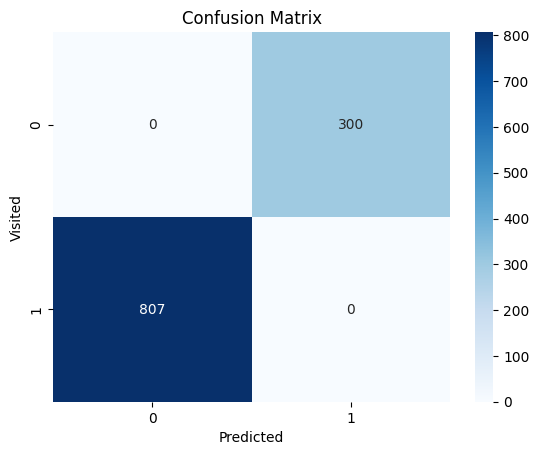

              precision  recall  f1-score  support
0                   0.0     0.0       0.0    300.0
1                   0.0     0.0       0.0    807.0
accuracy            0.0     0.0       0.0      0.0
macro avg           0.0     0.0       0.0   1107.0
weighted avg        0.0     0.0       0.0   1107.0


In [57]:
# Generar y_test y y_test_pred
y_test = []
y_test_pred = []

for id_user in test_df['id_user'].unique():
    recommendations = get_recommendations(id_user, train_df, test_df, train_cosine_sim)

    relevant_items = test_df[test_df['id_user'] == id_user]['id_business'].values

    # Si no hay recomendaciones, registrar un 0 en y_test para todos los ítems relevantes
    if recommendations.empty:
        for item in relevant_items:
            y_test.append(1)
            y_test_pred.append(0)
        print(f"No se encontraron recomendaciones para el usuario {id_user}.")
        continue

    recommended_items = recommendations['id_business'].values

    for item in relevant_items:
        y_test.append(1)
        if item in recommended_items:
            y_test_pred.append(1)
        else:
            y_test_pred.append(0)

    for item in recommended_items:
        if item not in relevant_items:
            y_test.append(0)
            y_test_pred.append(1)

# Verificar el contenido de las listas y_test y y_test_pred
print("y_test:", y_test)
print("y_test_pred:", y_test_pred)

# Calcular el reporte de clasificación
report = classification_report(y_test, y_test_pred, output_dict=True)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Visited')
plt.title('Confusion Matrix')
plt.show()

# Convertir el reporte a un DataFrame para una mejor visualización
report_df = pd.DataFrame(report).transpose()
print(report_df)

In [58]:
# Calcular NDCG
ndcg = ndcg_score([y_test], [y_test_pred])
print(f"NDCG: {ndcg}")

NDCG: 0.835001076426025


### Observaciones:
* La evaluación del modelo por la matriz de confusión y por recall, precision, f1-score y accuracy funciona muy mal. 
* La evaluación del modelo por NDCG funciona de forma adecuada.
* Las primeras dos observaciones plantean lo siguiente:
  * El dataset ha sido muy recortado. Aunque lo extraño que los lugares que sí visitó el usuario, tampoco estaría recomendando el sistema.
  * No sirve evaluar el modelo entre lo que predice y las reseñas de cada usuario en los establecimientos. El sistema podria estar dando recomendaciones acertadas pero el usuario no los ha visitado, y el usuario visita lugares que no son adecuados para ellos. 
  * Del anterior, lo ideal sería implementar el sistema de recomendación en producción, y registrar las reseñas de los usuarios que efectivamente visitaron el establecimiento segun recomendación del sistema. Esto será un KPI y creo que es la mejor forma de medir el sistema.
  * El filtro solo de contenido no es útil. Los usuarios quizás se guian por otras cuestiones, como las calificaciones de los negocios y las reseñas de otros usuarios.


### Planteos:
1. Aunque no se pueda evaluar, un sistema de recomendación por contenido en base a filtros que el usuario puede escoger, podria ser una buena alternativa para empezar.
2. Aunque la evaluación del modelo por filtro de contenido no ha sido bien evaluado, podria implementarse en producción (etapas futuras de este proyecto) y registrar el feedback del usuario.
3. Se puede agregar más filtros para que el usuario en cuestión tenga la posibilidad de elegir y probar cuál le funciona mejor.
4. Se podría implementar análisis de sentimiento en las reseñas de cada usuario.

### Endpoint 3: Filtro colaborativo basado en la calificación 'user_rating'

Filtros aplicados:
* Filtra los restaurantes segun avg_rating
* Filtra los restaurantes según ciudad.

Para cada usuario en el conjunto de prueba:
* Obtiene las valoraciones del usuario y encuentra usuarios similares.
* Calcula la puntuación ponderada para cada restaurante basándose en las similitudes entre usuarios.
* Selecciona los restaurantes con las mayores puntuaciones ponderadas y los ordena.
* Devuelve un DataFrame con las recomendaciones y la columna similarity formateada en porcentajes.

In [33]:
# Función para realizar los filtros iniciales según la ciudad y calificación mínima
def filter_df(df, city_name=None, min_rating=4):
    filtered_df = df.copy()
    if city_name:
        filtered_df = filtered_df[filtered_df['city_name'] == city_name]
    filtered_df = filtered_df[filtered_df['avg_rating'] >= min_rating]
    return filtered_df

# Aplicar los filtros dinámicamente
city_name = "Philadelphia"  # Cambia este valor si deseas otra ciudad, None para no filtrarlo
min_rating = 4  # Cambia este valor si deseas otro rating mínimo

df_ml_3_3 = filter_df(df_ml_3, city_name=city_name, min_rating=min_rating)

# Filtrar un subconjunto de usuarios más activos
active_users = df_ml_3_3['id_user'].value_counts().head(100).index.tolist()  # Convertir a lista
df_ml_3_3 = df_ml_3_3[df_ml_3_3['id_user'].isin(active_users)]

# Filtrar solo las reseñas de 4 o 5 estrellas
df_ml_3_3['avg_rating_binary'] = df_ml_3_3['avg_rating'].apply(lambda x: 1 if x >= 4 else 0)

# Crear una matriz de usuario-restaurante basada en las reseñas de 4 o 5 estrellas
user_restaurant_matrix = df_ml_3_3.pivot_table(index='id_user', columns='business_name', values='avg_rating_binary')
user_restaurant_matrix.fillna(0, inplace=True)

# Reducir la dimensionalidad con TruncatedSVD
svd = TruncatedSVD(n_components=100)
user_restaurant_matrix_reduced = svd.fit_transform(user_restaurant_matrix)

# Calcular la similitud entre usuarios usando la matriz reducida
user_similarity = cosine_similarity(user_restaurant_matrix_reduced)
user_similarity_df = pd.DataFrame(user_similarity, index=user_restaurant_matrix.index, columns=user_restaurant_matrix.index)

# Separar en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(df_ml_3_3, test_size=0.2, random_state=42)

# Crear la matriz usuario-restaurante para entrenamiento
train_user_restaurant_matrix = train_df.pivot_table(index='id_user', columns='business_name', values='avg_rating_binary')
train_user_restaurant_matrix.fillna(0, inplace=True)

# Función de recomendaciones colaborativas
def get_recommendations(id_user, n_recommendations=3, user_restaurant_matrix=train_user_restaurant_matrix, user_similarity_df=user_similarity_df, sample_df=train_df):
    avg_ratings = user_restaurant_matrix.loc[id_user]
    similar_users = user_similarity_df[id_user].sort_values(ascending=False)
    weighted_ratings = user_restaurant_matrix.T.dot(similar_users)
    
    scaler = MinMaxScaler()
    weighted_ratings = pd.Series(scaler.fit_transform(weighted_ratings.values.reshape(-1, 1)).flatten(), index=weighted_ratings.index)
    
    rated_restaurants = avg_ratings[avg_ratings == 1].index
    weighted_ratings.drop(rated_restaurants, inplace=True)
    
    top_recommendations = weighted_ratings.sort_values(ascending=False).head(n_recommendations)    
    # Crear el DataFrame de recomendaciones con el mismo índice que top_recommendations
    recommendations = sample_df[sample_df['business_name'].isin(top_recommendations.index)].copy()
    
    # Emparejar y asignar las similitudes correctas
    similarity_dict = top_recommendations.to_dict()
    recommendations['similarity'] = recommendations['business_name'].map(similarity_dict)  
    recommendations['similarity'] = recommendations['similarity'].apply(lambda x: "{:.2f}%".format(x * 100))

    # Ordenar por weighted_rating en orden descendente
    recommendations.sort_values(by='weighted_rating', ascending=False, inplace=True)
    # Eliminar duplicados basados en 'business_name' y 'business_address'
    recommendations.drop_duplicates(subset=['business_name', 'business_address'], inplace=True)
    recommendations.reset_index(drop=True, inplace=True)  # Ajustar los índices después del drop duplicates
        
    # Seleccionar y devolver solo las columnas especificadas en el orden solicitado, omitiendo 'weighted_rating'
    return recommendations[['business_name', 'category_name', 'similarity', 'city_name', 'business_address', 'avg_rating', 'region', 'hours']].head(n_recommendations)

# Seleccionar un id_user aleatorio del DataFrame de entrenamiento
random_user = random.choice(train_df['id_user'].unique())

# Obtener recomendaciones para el usuario aleatorio
recommendations = get_recommendations(random_user, n_recommendations=3)

# Mostrar las tres primeras recomendaciones
print(f"Recommended Restaurants for user {random_user} in {city_name} with min rating {min_rating}:")
recommendations

Recommended Restaurants for user 7qBgGzyf0FbHKC0jiI1J8A in Philadelphia with min rating 4:


,business_name,category_name,similarity,city_name,business_address,avg_rating,region,hours
0,Parc,Restaurants,82.14%,Philadelphia,227 S 18th St,4.346847,Global,"{'Friday': '11:0-0:0', 'Monday': '11:0-22:0', ..."
1,Talula's Garden,Restaurants,69.67%,Philadelphia,210 W Washington Sq,4.448276,Global,"{'Friday': '16:0-21:0', 'Monday': '0:0-0:0', '..."
2,Oyster House,Restaurants,74.26%,Philadelphia,1516 Sansom St,4.375000,Global,"{'Friday': '11:30-22:0', 'Monday': None, 'Satu..."


In [32]:
# Encuentra la city_name que más se repite
top_city = df_ml_3['city_name'].mode()[0]

# Filtra el DataFrame por la city_name que más se repite
df_ml_3_3 = df_ml_3[df_ml_3['city_name'] == top_city]

# Filtrar un subconjunto de usuarios más activos
active_users = df_ml_3_3['id_user'].value_counts().head(100).index.tolist()  # Convertir a lista
df_ml_3_3 = df_ml_3_3[df_ml_3_3['id_user'].isin(active_users)]

# Filtrar solo las reseñas de 4 o 5 estrellas
df_ml_3_3['avg_rating_binary'] = df_ml_3_3['avg_rating'].apply(lambda x: 1 if x >= 4 else 0)

# Crear una matriz de usuario-restaurante basada en las reseñas de 4 o 5 estrellas
user_restaurant_matrix = df_ml_3_3.pivot_table(index='id_user', columns='business_name', values='avg_rating_binary')
user_restaurant_matrix.fillna(0, inplace=True)

# Reducir la dimensionalidad con TruncatedSVD
svd = TruncatedSVD(n_components=100)
user_restaurant_matrix_reduced = svd.fit_transform(user_restaurant_matrix)

# Calcular la similitud entre usuarios usando la matriz reducida
user_similarity = cosine_similarity(user_restaurant_matrix_reduced)
user_similarity_df = pd.DataFrame(user_similarity, index=user_restaurant_matrix.index, columns=user_restaurant_matrix.index)

# Separar en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(df_ml_3_3, test_size=0.2, random_state=42)

# Crear la matriz usuario-restaurante para entrenamiento
train_user_restaurant_matrix = train_df.pivot_table(index='id_user', columns='business_name', values='avg_rating_binary')
train_user_restaurant_matrix.fillna(0, inplace=True)

# Función de recomendaciones colaborativas
def get_recommendations(id_user, n_recommendations=3, user_restaurant_matrix=train_user_restaurant_matrix, user_similarity_df=user_similarity_df, sample_df=train_df, city_name=None, min_rating=4):
    if city_name:
        sample_df = sample_df[sample_df['city_name'] == city_name]
    
    sample_df = sample_df[sample_df['avg_rating'] >= min_rating]

    avg_ratings = user_restaurant_matrix.loc[id_user]
    similar_users = user_similarity_df[id_user].sort_values(ascending=False)
    weighted_ratings = user_restaurant_matrix.T.dot(similar_users)
    
    scaler = MinMaxScaler()
    weighted_ratings = pd.Series(scaler.fit_transform(weighted_ratings.values.reshape(-1, 1)).flatten(), index=weighted_ratings.index)
    
    rated_restaurants = avg_ratings[avg_ratings == 1].index
    weighted_ratings.drop(rated_restaurants, inplace=True)
    
    top_recommendations = weighted_ratings.sort_values(ascending=False).head(n_recommendations)    
    # Crear el DataFrame de recomendaciones con el mismo índice que top_recommendations
    recommendations = sample_df[sample_df['business_name'].isin(top_recommendations.index)].copy()

    # Emparejar y asignar las similitudes correctas
    similarity_dict = top_recommendations.to_dict()
    recommendations['similarity'] = recommendations['business_name'].map(similarity_dict)  
    recommendations['similarity'] = recommendations['similarity'].apply(lambda x: "{:.2f}%".format(x * 100))

    # Ordenar por weighted_rating en orden descendente
    recommendations.sort_values(by='weighted_rating', ascending=False, inplace=True)
    # Eliminar duplicados basados en 'business_name' y 'business_address'
    recommendations.drop_duplicates(subset=['business_name', 'business_address'], inplace=True)
    recommendations.reset_index(drop=True, inplace=True)  # Ajustar los índices después del drop duplicates
        
    # Seleccionar y devolver solo las columnas especificadas en el orden solicitado, omitiendo 'weighted_rating'
    return recommendations[['business_name', 'category_name', 'similarity', 'city_name', 'business_address', 'avg_rating', 'region', 'hours']].head(n_recommendations)

# Seleccionar un id_user aleatorio del DataFrame de entrenamiento
random_user = random.choice(train_df['id_user'].unique())

# Obtener recomendaciones para el usuario aleatorio con ciudad y rating mínimo personalizados
city_name = "Philadelphia"  # Cambia este valor si deseas otra ciudad
min_rating = 4  # Cambia este valor si deseas otro rating mínimo, el valor por defecto es 4

recommendations = get_recommendations(random_user, n_recommendations=3, city_name=city_name, min_rating=min_rating)

# Mostrar las tres primeras recomendaciones
print(f"Recommended Restaurants for user {random_user} in {city_name} with min rating {min_rating}:")
recommendations

Recommended Restaurants for user OExmdhEdcKHQQqXrv6ftTg in Philadelphia with min rating 4:


,business_name,category_name,similarity,city_name,business_address,avg_rating,region,hours
0,Reading Terminal Market,Restaurants,81.62%,Philadelphia,51 N 12th St,4.788321,Global,"{'Friday': '8:0-18:0', 'Monday': '8:0-18:0', '..."
1,Barbuzzo,Restaurants,100.00%,Philadelphia,110 S 13th St,4.082278,Global,"{'Friday': '17:0-23:0', 'Monday': '17:0-22:0',..."
2,Oyster House,Restaurants,72.82%,Philadelphia,1516 Sansom St,4.375000,Global,"{'Friday': '11:30-22:0', 'Monday': None, 'Satu..."


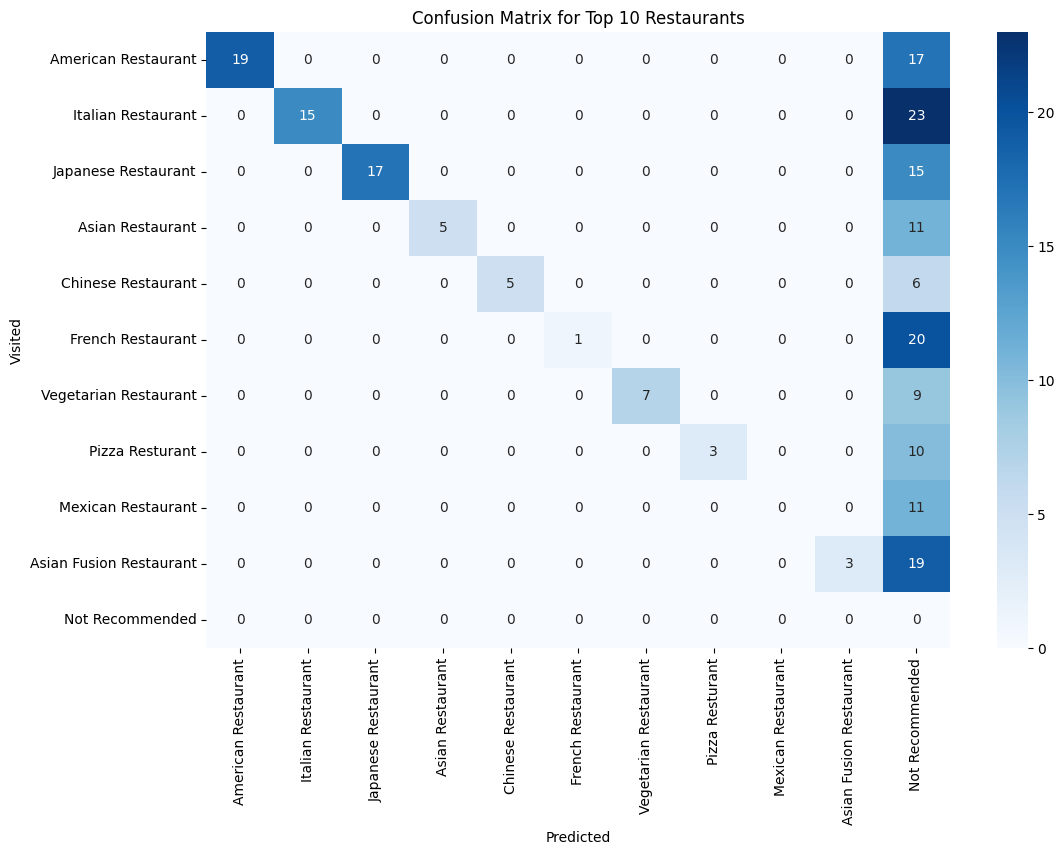

Classification Report:
                         precision    recall  f1-score   support

    American Restaurant       1.00      0.53      0.69        36
     Italian Restaurant       1.00      0.39      0.57        38
    Japanese Restaurant       1.00      0.53      0.69        32
       Asian Restaurant       1.00      0.31      0.48        16
     Chinese Restaurant       1.00      0.45      0.62        11
      French Restaurant       1.00      0.05      0.09        21
  Vegetarian Restaurant       1.00      0.44      0.61        16
        Pizza Resturant       1.00      0.23      0.38        13
     Mexican Restaurant       0.00      0.00      0.00        11
Asian Fusion Restaurant       1.00      0.14      0.24        22
        Not Recommended       0.00      0.00      0.00         0

               accuracy                           0.35       216
              macro avg       0.82      0.28      0.40       216
           weighted avg       0.95      0.35      0.49       216


c:\Users\Josue\OneDrive\Data_Scientist\Henry\Bootcamp\10. PF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Josue\OneDrive\Data_Scientist\Henry\Bootcamp\10. PF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Josue\OneDrive\Data_Scientist\Henry\Bootcamp\10. PF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior

In [60]:
# Evaluar el modelo con el conjunto de prueba considerando los 10 primeros restaurantes
y_true = []
y_pred = []
top_10_restaurants = df_ml_3_3['business_name'].value_counts().index[:10]  # Seleccionar los 10 restaurantes más comunes

for id_user in test_df['id_user'].unique():
    actual_restaurants = test_df[test_df['id_user'] == id_user]['business_name'].values[:10]  # Considerar los 10 primeros restaurantes
    recommendations = get_recommendations(id_user, user_restaurant_matrix=train_user_restaurant_matrix, user_similarity_df=user_similarity_df)
    recommended_restaurants = recommendations['business_name'].values
    
    # Evaluación
    for restaurant in actual_restaurants:
        if restaurant in top_10_restaurants:  # Considerar solo los 10 restaurantes más comunes
            y_true.append(restaurant)
            if restaurant in recommended_restaurants:
                y_pred.append(restaurant)
            else:
                y_pred.append("Not Recommended")

# Calcular la matriz de confusión solo para los 10 restaurantes más comunes
cm = confusion_matrix(y_true, y_pred, labels=list(top_10_restaurants) + ["Not Recommended"])

# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(top_10_restaurants) + ["Not Recommended"], yticklabels=list(top_10_restaurants) + ["Not Recommended"])
plt.xlabel('Predicted')
plt.ylabel('Visited')
plt.title('Confusion Matrix for Top 10 Restaurants')
plt.show()

# Calcular y mostrar el reporte de clasificación
print("Classification Report:")
print(classification_report(y_true, y_pred, labels=list(top_10_restaurants) + ["Not Recommended"]))

# Calcular y mostrar la precisión del modelo
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Calcular la métrica NDCG
# Generar una lista binaria para y_true
y_true_binary = [1 if restaurant in y_true else 0 for restaurant in recommended_restaurants]
# Calcular el NDCG
ndcg = ndcg_score([y_true_binary], [list(recommendations['similarity'].str.rstrip('%').astype('float') / 100)])
print("NDCG Score:", ndcg)

Consideraciones:
1. Revisar los endpoints y checkarlos
2. Ver de implmenetar un filtro combinando user_rating y user_business
3. implementar el ultimo con calificaciones de 5 estrellas, ver si puedo aplicarle un filtro combinando el del rating o el de contenido

### Endpoint 4: Filtro híbrido colaborativo basado en la calificación 'user_rating' y análisis por aspecto

Filtros aplicados:
* Filtra los restaurantes segun avg_rating
* Filtra los restaurantes según ciudad.

Para cada usuario en el conjunto de prueba:
* Obtiene las valoraciones del usuario y encuentra usuarios similares.
* Calcula la puntuación ponderada para cada restaurante basándose en las similitudes entre usuarios.
* Selecciona los restaurantes con las mayores puntuaciones ponderadas y los ordena.
* Devuelve un DataFrame con las recomendaciones y la columna similarity formateada en porcentajes.

In [19]:
# Función para realizar los filtros iniciales según la ciudad, calificación mínima y aspecto
def filter_df(df, city_name=None, min_rating=4, aspect=None):
    filtered_df = df.copy()
    if city_name:
        filtered_df = filtered_df[filtered_df['city_name'] == city_name]
    filtered_df = filtered_df[filtered_df['avg_rating'] >= min_rating]
    if aspect:
        filtered_df = filtered_df[filtered_df['aspect'] == aspect]  # Ajusta esta línea según cómo almacenes los aspectos
    return filtered_df

# Aplicar los filtros dinámicamente

aspect = "food_sentiment"  # Cambia este valor para especificar el aspecto que deseas priorizar

df_ml_4_1 = filter_df(df_ml_4, aspect=aspect)  # Agregué el parámetro 'aspect'

# Filtrar un subconjunto de usuarios más activos
active_users = df_ml_3_3['id_user'].value_counts().head(100).index.tolist()  # Convertir a lista
df_ml_3_3 = df_ml_3_3[df_ml_3_3['id_user'].isin(active_users)]

# Filtrar solo las reseñas de 4 o 5 estrellas
df_ml_3_3['avg_rating_binary'] = df_ml_3_3['avg_rating'].apply(lambda x: 1 if x >= 4 else 0)

# Crear una matriz de usuario-restaurante basada en las reseñas de 4 o 5 estrellas
user_restaurant_matrix = df_ml_3_3.pivot_table(index='id_user', columns='business_name', values='avg_rating_binary')
user_restaurant_matrix.fillna(0, inplace=True)

# Reducir la dimensionalidad con TruncatedSVD
svd = TruncatedSVD(n_components=100)
user_restaurant_matrix_reduced = svd.fit_transform(user_restaurant_matrix)

# Calcular la similitud entre usuarios usando la matriz reducida
user_similarity = cosine_similarity(user_restaurant_matrix_reduced)
user_similarity_df = pd.DataFrame(user_similarity, index=user_restaurant_matrix.index, columns=user_restaurant_matrix.index)

# Separar en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(df_ml_3_3, test_size=0.2, random_state=42)

# Crear la matriz usuario-restaurante para entrenamiento
train_user_restaurant_matrix = train_df.pivot_table(index='id_user', columns='business_name', values='avg_rating_binary')
train_user_restaurant_matrix.fillna(0, inplace=True)

# Función de recomendaciones colaborativas
def get_recommendations(id_user, n_recommendations=3, user_restaurant_matrix=train_user_restaurant_matrix, user_similarity_df=user_similarity_df, sample_df=train_df):
    avg_ratings = user_restaurant_matrix.loc[id_user]
    similar_users = user_similarity_df[id_user].sort_values(ascending=False)
    weighted_ratings = user_restaurant_matrix.T.dot(similar_users)
    
    scaler = MinMaxScaler()
    weighted_ratings = pd.Series(scaler.fit_transform(weighted_ratings.values.reshape(-1, 1)).flatten(), index=weighted_ratings.index)
    
    rated_restaurants = avg_ratings[avg_ratings == 1].index
    weighted_ratings.drop(rated_restaurants, inplace=True)
    
    top_recommendations = weighted_ratings.sort_values(ascending=False).head(n_recommendations)    
    # Crear el DataFrame de recomendaciones con el mismo índice que top_recommendations
    recommendations = sample_df[sample_df['business_name'].isin(top_recommendations.index)].copy()
    
    # Emparejar y asignar las similitudes correctas
    similarity_dict = top_recommendations.to_dict()
    recommendations['similarity'] = recommendations['business_name'].map(similarity_dict)  
    recommendations['similarity'] = recommendations['similarity'].apply(lambda x: "{:.2f}%".format(x * 100))

    # Ordenar por weighted_rating en orden descendente
    recommendations.sort_values(by='weighted_rating', ascending=False, inplace=True)
    # Eliminar duplicados basados en 'business_name' y 'business_address'
    recommendations.drop_duplicates(subset=['business_name', 'business_address'], inplace=True)
    recommendations.reset_index(drop=True, inplace=True)  # Ajustar los índices después del drop duplicates
        
    # Seleccionar y devolver solo las columnas especificadas en el orden solicitado, omitiendo 'weighted_rating'
    return recommendations[['business_name', 'category_name', 'similarity', 'city_name', 'business_address', 'avg_rating', 'region', 'hours']].head(n_recommendations)

# Seleccionar un id_user aleatorio del DataFrame de entrenamiento
random_user = random.choice(train_df['id_user'].unique())

# Obtener recomendaciones para el usuario aleatorio
recommendations = get_recommendations(random_user, n_recommendations=3)

# Mostrar las tres primeras recomendaciones
print(f"Recommended Restaurants for user {random_user} in {city_name} with min rating {min_rating}:")
recommendations


KeyError: 'aspect'

### Endpoint 5: Recomendación basado en la calificación más alta que el usuario asigno a un restaurant

Cómo Funciona el Sistema

Filtrado de usuarios activos: Filtra a los 100 usuarios más activos del DataFrame sample_df_2.

División de datos: Divide los datos en conjuntos de entrenamiento (train_df) y prueba (test_df).

Combinar cuisine y restaurant_name: Combina las columnas cuisine y restaurant_name para crear una nueva columna cuisine_restaurant.

Vectorización de descripciones: Vectoriza las descripciones de la nueva columna combinada utilizando TF-IDF.

Similitud coseno: Calcula la similitud coseno entre los restaurantes en el conjunto de entrenamiento.

Recomendación:

Para cada usuario en el conjunto de prueba:

Filtra las interacciones del usuario con calificaciones de 5 estrellas.

Ordena los restaurantes por business_rating y selecciona los 3 más altos.

Calcula la similitud promedio para los restaurantes recomendados y los convierte a porcentajes.

Devuelve un DataFrame con las recomendaciones y la columna similarity formateada en porcentajes

In [ ]:
# Encuentra la city_name que más se repite
top_city = df_ml_3['city_name'].mode()[0]

# Filtra el DataFrame por la city_name que más se repite
df_ml_3_4 = df_ml_3[df_ml_3['city_name'] == top_city]

# Filtrar un subconjunto de usuarios más activos
active_users = df_ml_3_4['id_user'].value_counts().head(100).index.tolist()  # Convertir a lista
df_ml_3_4 = df_ml_3_4[df_ml_3_4['id_user'].isin(active_users)]


# Dividir los datos en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(df_ml_3, test_size=0.2, random_state=42)

# Verificar el tamaño de los conjuntos de datos
print(f"Tamaño del conjunto de entrenamiento: {train_df.shape}")
print(f"Tamaño del conjunto de prueba: {test_df.shape}")

# Reindexar el DataFrame de entrenamiento
train_df = train_df.reset_index(drop=True)

# Asegurarse de que no hay valores nulos en 'description'
train_df['description'] = train_df['description'].fillna('')

# Crear la matriz TF-IDF para la nueva columna combinada
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(train_df['description'])

# Calcular la similitud coseno
cosine_sim = cosine_similarity(tfidf_matrix)

# Convertir la matriz de similitud coseno en un DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim, index=train_df.index, columns=train_df.index)

# Crear una función de recomendación basada en calificaciones de 5 estrellas y filtrar por los 3 avg_rating más altos
def get_top_rated_recommendation(id_user, df, sim_df):
    user_interactions = df[(df['id_user'] == id_user) & (df['avg_rating'] == 5)]
    if user_interactions.empty:
        return pd.DataFrame(columns=['business_name', 'category_name', 'similarity', 'city_name', 'business_address', 'avg_rating', 'region', 'hours'])  # Devolver DataFrame vacío si el usuario no tiene interacciones de 5 estrellas
    
    # Ordenar por avg_rating y seleccionar los 3 más altos
    top_rated = user_interactions.sort_values(by='avg_rating', ascending=False).head(3)
    
    # Calcular la similitud promedio para los restaurantes recomendados
    similarities = []
    for idx in top_rated.index:
        sim_scores = sim_df.loc[idx].values
        sim_avg = sim_scores.mean()
        similarities.append(f"{sim_avg * 100:.2f}%")  # Convertir la similitud a porcentajes y agregar el símbolo %
    
    top_rated['similarity'] = similarities
    
    # Reordenar las columnas en el DataFrame de recomendaciones
    recommendations = top_rated[['business_name', 'category_name', 'similarity', 'city_name', 'business_address', 'avg_rating', 'region', 'hours']]
    
    return recommendations

# Generar una recomendación para un usuario en el conjunto de prueba
test_id_user = df_ml_3_4['id_user'].sample(n=1).iloc[0]  # Seleccionar un usuario al azar del subconjunto
print(f"Recomendaciones basadas en las calificaciones de 5 estrellas y los 3 avg_rating más altos para el usuario: {test_id_user}")
top_rated_recommendation = get_top_rated_recommendation(test_id_user, train_df, cosine_sim_df)

print("Recomendaciones basadas en las calificaciones de 5 estrellas y los 3 avg_rating más altos:")
top_rated_recommendation

Tamaño del conjunto de entrenamiento: (6338712, 12)
Tamaño del conjunto de prueba: (1584678, 12)


### Endpoint 5: Recomendación basado en un filtro híbrido

Criterios:
* Sistema 1: Basado en Calificaciones de Usuarios: Filtra y recomienda restaurantes que el usuario ha calificado con 5 estrellas.
* Sistema 2: Basado en Similitud Coseno: Calcula la similitud coseno combinando las variables cuisine y restaurant_name.
* Sistema 3: Filtrado por los 3 business_rating más altos: Recomienda los tres restaurantes con las calificaciones más altas (business_rating).

In [62]:
# Crear una copia del DataFrame para evitar modificaciones en el original
df_ml_3_5 = df_ml_3_3.copy()

# Dividir los datos en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(df_ml_3_5, test_size=0.2, random_state=42)

# Verificar el tamaño de los conjuntos de datos
print(f"Tamaño del conjunto de entrenamiento: {train_df.shape}")
print(f"Tamaño del conjunto de prueba: {test_df.shape}")

# Reindexar el DataFrame de entrenamiento
train_df = train_df.reset_index(drop=True)

# Combinar 'cuisine' y 'business_name' en una nueva columna
train_df['cuisine_restaurant'] = train_df['cuisine'] + ' ' + train_df['business_name']

# Crear la matriz TF-IDF para la nueva columna combinada
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(train_df['cuisine_restaurant'])

# Calcular la similitud coseno
cosine_sim = cosine_similarity(tfidf_matrix)

# Convertir la matriz de similitud coseno en un DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim, index=train_df.index, columns=train_df.index)

# Función para obtener recomendaciones híbridas
def get_hybrid_recommendation(id_user, df, sim_df):
    user_interactions = df[df['id_user'] == id_user]
    visited_restaurants = user_interactions['business_name'].tolist()
    
    # Filtrar restaurantes no visitados por el usuario
    not_visited_df = df[~df['business_name'].isin(visited_restaurants)]
    
    # Calcular la similitud coseno y ordenar por business_rating
    not_visited_df['similarity'] = not_visited_df.index.map(lambda idx: sim_df.loc[idx].mean() * 100)
    top_recommendations = not_visited_df.sort_values(by=['similarity', 'business_rating'], ascending=False).head(3)
    
    # Formatear la columna similarity con el término %
    top_recommendations['similarity'] = top_recommendations['similarity'].apply(lambda x: f"{x:.2f}%")
    
    # Reordenar las columnas en el DataFrame de recomendaciones
    recommendations = top_recommendations[['business_name', 'similarity', 'business_city', 'postal_code', 'business_rating', 'cuisine']]
    
    return recommendations

# Generar una recomendación para un usuario en el conjunto de prueba
test_id_user = df_ml_3_5['id_user'].sample(n=1).iloc[0]  # Seleccionar un usuario al azar del subconjunto
print(f"Recomendaciones híbridas para el usuario: {test_id_user}")
hybrid_recommendation = get_hybrid_recommendation(test_id_user, train_df, cosine_sim_df)

print("Recomendaciones híbridas:")
hybrid_recommendation

Tamaño del conjunto de entrenamiento: (2582, 10)
Tamaño del conjunto de prueba: (646, 10)
Recomendaciones híbridas para el usuario: 709161
Recomendaciones híbridas:


C:\Users\Josue\AppData\Local\Temp\ipykernel_2776\4145710907.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_visited_df['similarity'] = not_visited_df.index.map(lambda idx: sim_df.loc[idx].mean() * 100)


,restaurant_name,similarity,business_city,postal_code,business_rating,cuisine
265,American Restaurant,17.03%,New York,10009,4.9,Regional-American Cuisine
623,American Restaurant,17.03%,New York,10014,4.8,Regional-American Cuisine
1168,American Restaurant,17.03%,New York,10012,4.7,Regional-American Cuisine
